In [1]:
using Revise
includet("../../utils/file_reader.jl")
includet("../../utils/some_data.jl")
includet("../../utils/utils_graph.jl")
includet("../../resolution/compact/compact_formulation.jl")
includet("../../utils/visu.jl")
includet("../../resolution/vndecompo/vn_decompo.jl")

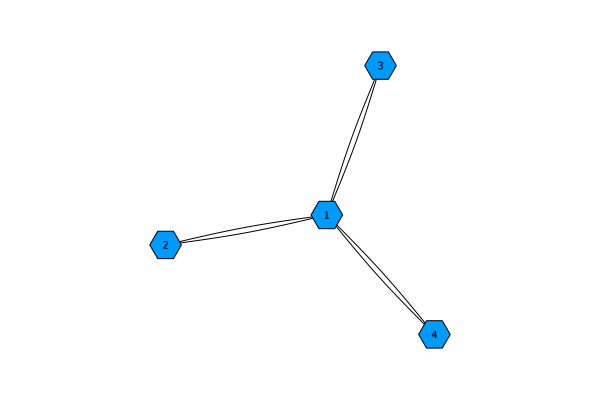

In [2]:
instance = get_instance_from_folder("instance1")
visu_graph(instance.v_networks[1])


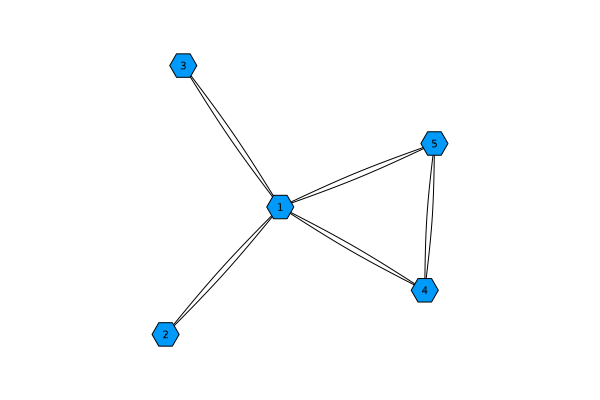

In [3]:
visu_graph(instance.s_network)


### Resolution classique

### Relaxation linéaire

In [13]:
mappings = solve_compact_fractional(instance, false, false)
println("Valeur de la relaxation linéaire en mode naze : " * string(mappings[1].node_placement_cost + mappings[1].edge_routing_cost))

Constructing compact model...CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_TimeLimit                               10
CPXPARAM_MIP_Tolerances_Integrality              1e-08
Tried aggregator 1 time.
LP Presolve eliminated 161 rows and 0 columns.
Aggregator did 104 substitutions.
Reduced LP has 73 rows, 159 columns, and 510 nonzeros.
Presolve time = 0.00 sec. (0.39 ticks)
Symmetry aggregator did 98 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             5.000000

Dual crossover.
  Dual:  Fixed no variables.
  Primal:  Fixed no variables.
Valeur de la relaxation linéaire en mode naze : 5.000000000000002

In [6]:
mappings = solve_compact_fractional(instance, true, true)
println("Valeur de la relaxation linéaire en gucci : " * string(mappings[1].node_placement_cost + mappings[1].edge_routing_cost))

Constructing compact model...CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_TimeLimit                               10
CPXPARAM_MIP_Tolerances_Integrality              1e-08
Tried aggregator 1 time.
LP Presolve eliminated 85 rows and 0 columns.
Aggregator did 30 substitutions.
Reduced LP has 59 rows, 50 columns, and 250 nonzeros.
Presolve time = 0.00 sec. (0.17 ticks)
Symmetry aggregator did 21 additional substitutions.

Iteration log . . .
Iteration:     1   Dual objective     =             1.000000

Dual crossover.
  Dual:  Fixing 15 variables.
       14 DMoves:  Infeasibility  0.00000000e+00  Objective  1.00000000e+01
        0 DMoves:  Infeasibility  0.00000000e+00  Objective  1.00000000e+01
  Dual:  Pushed 0, exchanged 15.
  Primal:  Fixing 1 variable.
        0 PMoves:  Infeasibility  0.00000000e+00  Objective  1.00000000e+01
  Primal:  Pushed 1, exchanged 0.
Valeur de la relaxation linéaire en gucci : 10.0

### Column Generation

In [20]:
#node_partitionning = [[[2, 3, 4], [5, 6, 7, 8, 9, 1]]]
#vn_decompo_old(instance, node_partitionning)

In [21]:
node_partitionning = [[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15, 16]]]
vn_decompo(instance, node_partitionning);

Starting solving...


Master problem set... Initial set of columns generated... 

Starting column generation: 
Iter 0

, CG value : 124.0


Iter 1, CG value : 124.0


Iter 2, CG value : 124.0


Iter 3, CG value : 110.66666666666663


Iter 4, CG value : 108.0


Iter 5, CG value : 107.33333333333333


Iter 6, CG value : 107.33333333333334


Iter 7, CG value : 107.33333333333331


Iter 8, CG value : 106.66666666666669


Iter 9, CG value : 106.66666666666669


Iter 10, CG value : 105.52380952380956


Iter 11, CG value : 105.52380952380955


Iter 12, CG value : 105.52380952380955


Iter 13, CG value : 105.52380952380955


Iter 14, CG value : 105.52380952380955


Iter 15, CG value : 105.52380952380953


Iter 16, CG value : 103.66666666666667


Iter 17, CG value : 102.99999999999999


Iter 18, CG value : 102.99999999999999


Iter 19, CG value : 103.0


Iter 20, CG value : 102.0


Iter 21, CG value : 102.00000000000003


Iter 22, CG value : 102.0


Iter 23, CG value : 102.0


Iter 24, CG value : 101.80000000000001


Iter 25, CG value : 101.71428571428574


Iter 26, CG value : 101.71428571428572


Iter 27, CG value : 101.33333333333333


Iter 28, CG value : 101.33333333333333


Iter 29, CG value : 101.33333333333333


Iter 30, CG value : 101.33333333333333


Final value: 101.33333333333333
Time in MP: 0.7065496444702148, time in SP: 23.501634120941162


Value integer : 102.0


In [12]:
lambdas = master_problem.lambdas
# lambda_values = value.(model[:lambda])
y_values = value.(master_problem.model[:y])

subgraph_mapping = Dict()
connecting_edge_routing = Dict()

for v_network in instance.v_networks

    subgraph_mapping[v_network] = Dict()
    for subgraph in vn_decompos[v_network].subgraphs
        for mapping in vn_decompos[v_network].mappings[subgraph]
            if value(lambdas[v_network][subgraph][mapping]) > 0.5
                subgraph_mapping[v_network][subgraph] = mapping
            end
        end
    end

    connecting_edge_routing[v_network] = Dict()
    for v_edge in vn_decompos[v_network].connecting_edges
        used_edges = []
        node_assignment_src = vn_decompos[v_network].node_assignment[src(v_edge)]
        node_assignment_dst = vn_decompos[v_network].node_assignment[dst(v_edge)]
        for s_edge in edges(instance.s_network)
            if y_values[v_network, v_edge, s_edge] > 0.99
                push!(used_edges, s_edge)
            end
        end
        connecting_edge_routing[v_network][v_edge] = order_path(instance.s_network, used_edges, 
            subgraph_mapping[v_network][node_assignment_src[1]].node_placement[node_assignment_src[2]],
            subgraph_mapping[v_network][node_assignment_dst[1]].node_placement[node_assignment_dst[2]] )
    end

end



UndefVarError: UndefVarError: `master_problem` not defined

In [13]:
# From where, we get a solution in the classic format
mappings = []
for v_network in instance.v_networks
    
    # node placement
    node_placement = []
    for v_node in vertices(v_network)
        current_node_assignment = vn_decompos[v_network].node_assignment[v_node]
        push!(node_placement, subgraph_mapping[v_network][current_node_assignment[1]].node_placement[current_node_assignment[2]])
    end
    
    edge_routing = Dict()
    for v_edge in edges(v_network)
        node_assignment_src = vn_decompos[v_network].node_assignment[src(v_edge)]
        node_assignment_dst = vn_decompos[v_network].node_assignment[dst(v_edge)]
        if node_assignment_dst[1] == node_assignment_src[1]
            edge_routing[v_edge] = subgraph_mapping[v_network][node_assignment_src[1]].edge_routing[get_edge(node_assignment_src[1], node_assignment_src[2], node_assignment_dst[2])]
        elseif v_edge in vn_decompos[v_network].connecting_edges
            edge_routing[v_edge] = connecting_edge_routing[v_network][v_edge]
        else
            println("wut")
        end
    end

    push!(mappings, MappingClassic(v_network, instance.s_network, node_placement, edge_routing))
end



UndefVarError: UndefVarError: `vn_decompos` not defined